| [**Lattice QCD I**](https://homepages.uni-regensburg.de/~lec17310/teaching/wise2122/lqft.html) | - | [**Christoph Lehner**](https://go.ur.de/lehner) |
|:-|--|-:|

# Chapter 13: Hybrid Monte Carlo

In this chapter we discuss the Hybrid Monte Carlo (HMC) algorithm that can efficiently generate gauge configurations with dynamical fermions.  We go step-by-step and first introduce needed concepts.

## Molecular Dynamics

The Hamiltonian $H(q,p)$ with canonical coordinate $q$ and canonical momentum $p$
is constant under time-evolution of $p$ and $q$ following the equations of motion
$$
\begin{align}
\dot{q} &= \frac{\partial H}{\partial p} \,, & \dot{p} &= -\frac{\partial H}{\partial q} \,.
\end{align}
$$
They can therefore be used to simulate the evolution of a microcanonical ensemble (where the energy
is constant and specified).

Now consider a simple Hamiltonian
$$
\begin{align}
H(p,q) = \frac12 p^2 + V(q) \,,
\end{align}
$$
then the equations of motions are
$$
\begin{align}
\dot{q} &= p \,, &
\dot{p} &= -V'(q) \,.
\end{align}
$$

A simple numerical scheme to perform the Molecular Dynamics (MD) integration is the **Euler integrator**
$$
\begin{align}
p(t+dt) &= p(t) - V'(q(t)) dt \,, \\
q(t+dt) &= q(t) + p(t) dt \,.
\end{align}
$$

A better scheme is the **Leapfrog integrator**
$$
\begin{align}
p(t+dt/2) &= p(t) - V'(q(t)) dt/2 \,, \\
q(t+dt) &= q(t) + p(t+dt/2) dt \,, \\
p(t+dt) &= p(t+dt/2) - V'(q(t+dt)) dt/2 
\end{align}
$$
which is symplectic, i.e., it preserves the $dp \wedge dq$.  It preserves
the energy to high accuracy and is reversible as you will show in your homework.

***Homework***: Show for the Leapfrog that
$$
\begin{align}
H(p(t+dt),q(t+dt)) - H(p(t),q(t)) = O(dt^3)
\end{align}
$$
Show also that the Leapfrog is reversible, i.e., that evolving with
$-dt$ after evolving with $dt$ returns to the same identical (p,q).

Let us demonstrate these integrators in a simple example.

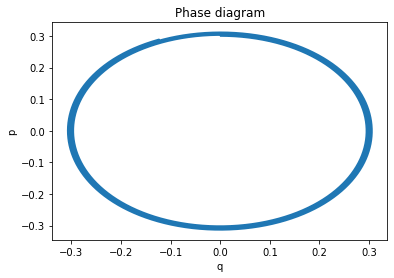

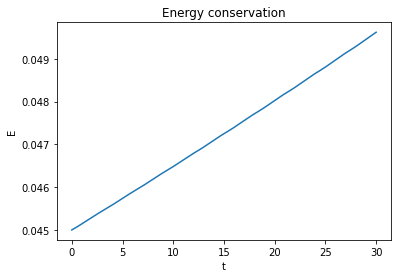

Reversibility test: 2.951175396656005e-06


In [14]:
import gpt as g
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate

def V(q):
    return 1.0/2.0*q**2 + 1.0/4.0 * q**4

def dV(q):
    return q + q**3

def integrator_euler(p, q, dt):
    return p - dV(q)*dt, q + p*dt
    
def plot(p, q, eps, integrator):
    x = []
    y = []
    t = []
    E = []
    for i in range(10000):
        p, q = integrator(p, q, eps)
        x.append(q)
        y.append(p)
        t.append(i*eps)
        E.append(p**2./2.0 + V(q))
    
    fig, ax = plt.subplots()
    plt.title("Phase diagram")
    plt.xlabel("q")
    plt.ylabel("p")
    ax.plot(x,y)
    plt.show()

    fig, ax = plt.subplots()
    plt.title("Energy conservation")
    ax.ticklabel_format(style="sci",useOffset=False)
    plt.xlabel("t")
    plt.ylabel("E")
    ax.plot(t,E)
    plt.show()
    
    # check reversibility
    p, q = integrator(p, q, -eps)
    delta = ((p - y[-2])**2. + (q - x[-2])**2.)**0.5
    print("Reversibility test:",delta)
    
plot(0.3, 0, 0.003, integrator_euler)

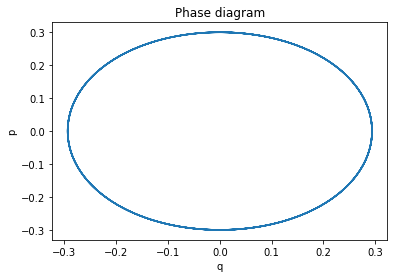

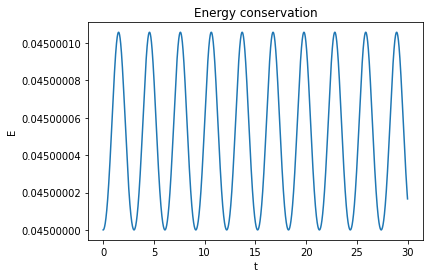

Reversibility test: 0.0


In [99]:
def integrator_leapfrog(p, q, dt):
    p_half = p - dV(q)*dt/2.
    q_one = q + p_half*dt
    p_one = p_half - dV(q_one)*dt/2.
    return p_one, q_one

plot(0.3, 0, 0.003, integrator_leapfrog)

## The path integral using Molecular Dynamics

Let us define a simple bosonic path integral
$$
\begin{align}
\langle O(q) \rangle &= \frac{\int dq O(q) e^{-V(q)}}{\int dq e^{-V(q)}} = \frac{\int dq dp O(q) e^{-V(q)-p^2/2}}{\int dq dp  e^{-V(q)-p^2/2}} \\
&= \frac{\int dq dp O(q) e^{-H(p,q)}}{\int dq dp e^{-H(p,q)}}
\end{align}
$$

If we now randomly pick momenta $p$ following the distribution
$$
e^{-p^2/2}
$$
and use an exact MD integrator to integrate a trajectory, we do not change $H(p,q)$.  If such a process were to be ergodic, i.e.,
any field configuration can be reached and reversible, then we can use the MD integration as a proposal step in the Metropolis algorithm of chapter 2.  Since the energy is conserved, all proposed configurations should be accepted.  Let us demonstrate this algorithm.

In [143]:
rng = g.random("hmc")

ref_val = (
    scipy.integrate.quad(lambda q:q**2.*np.exp(-q**2./2.-q**4./4.),-np.infty,np.infty)[0] 
    / scipy.integrate.quad(lambda q:np.exp(-q**2./2.-q**4./4.),-np.infty,np.infty)[0]
)

def md_integrate(rng, f, eps, trajectory_length, trajectories, integrator, verbose):
    q = 0.0
    ftot = 0.0
    dE2tot = 0.0
    for i in range(trajectories):
        p = rng.normal().real
        E0 = p**2./2. + V(q)
        for j in range(trajectory_length):
            p, q = integrator(p, q, eps)
        E1 = p**2./2. + V(q)
        dE2tot += (E1-E0)**2.
        ftot += f(q)
    if verbose:
        print("Energy changed by",(dE2tot / trajectories)**0.5)
    return ftot / trajectories
    
measurements = [md_integrate(rng, lambda q: q**2., 0.01, 100, 1000, integrator_leapfrog, j==0) for j in range(40)]
hmc_mean = np.mean(measurements)
hmc_err = np.std(measurements) / len(measurements)**0.5
print(hmc_mean,"+-",hmc_err)

print(ref_val)

GPT :   12129.165851 s : Initializing gpt.random(hmc,vectorized_ranlux24_389_64) took 0.000347853 s
Energy changed by 4.9812149431683414e-05
0.4693255931366978 +- 0.0026291580867840044
0.4679199169736833



## The Hybrid Monte Carlo algorithm

We cannot make the step size in the above algorithm much larger since we have a systematic error due to the non-conservation of energy.  This is, however, readily fixed by adding an accept-reject step.  Let us demonstrate:

In [144]:
def hmc_integrate(rng, f, eps, trajectory_length, trajectories, integrator, verbose):
    q = 0.0
    ftot = 0.0
    dE2tot = 0.0
    reject = 0
    accept = 0
    for i in range(trajectories):
        p = rng.normal().real
        E0 = p**2./2. + V(q)
        q0 = q
        for j in range(trajectory_length):
            p, q = integrator(p, q, eps)
        E1 = p**2./2. + V(q)
        if np.exp(E0-E1) < rng.uniform_real(min=0,max=1):
            reject += 1
            q = q0
        else:
            accept += 1
            dE2tot += (E1-E0)**2.
        ftot += f(q)
    if verbose:
        print("Energy changed by",(dE2tot / trajectories)**0.5)
        print("Acceptance rate",accept/(accept+reject))
    return ftot / trajectories
    
# can run with much larger stepsize, i.e., fewer steps within a trajectory, roughly same cost as MD above
# smaller statistical error compared to pure MD due to more uncorrelated configurations at same cost
measurements = [hmc_integrate(rng, lambda q: q**2., 0.8, 2, 50000, integrator_leapfrog, j==0) for j in range(40)]
hmc_mean = np.mean(measurements)
hmc_err = np.std(measurements) / len(measurements)**0.5
print(hmc_mean,"+-",hmc_err)

print(ref_val)

Energy changed by 0.371463895432758
Acceptance rate 0.80436
0.4676423573794918 +- 0.0009053735027992211
0.4679199169736833


***Homework:*** Use the HMC algorithm to compute $\int dx x^4 e^{-x^4} / \int dx e^{-x^4}$.

## Strength of the HMC

We can generate configurations that are to a large degree uncorrelated by evolving for a long time within a microcanonical ensemble.  This
performs an update that globally reduces correlation.  At the same time, we approximately conserve the Hamiltonian, so that we have a good acceptance rate even for large global field configuration changes.  This effectively reduces the autocorrelation compared to other global update schemes.  Local updating schemes such as the Heatbath are also very effective but require a specific restricted local form of the action.  The introduction of a fermion determinant, e.g., violates the local form of the action.  The HMC on the other hand can perform global updates while only requiring knowledge of the derivative of the action with respect to the field configuration.

## HMC generation of quenched ensemble

GPT :    2335.016326 s : Initializing gpt.random(test,vectorized_ranlux24_24_64) took 4.60148e-05 s
GPT :    2336.024092 s : HMC 0 has P = 0.7984117298395389, dS = 10379.119118396331, acceptance = 1.0
GPT :    2357.513546 s : HMC 25 has P = 0.510195708618931, dS = 532.1766394544538, acceptance = 0.6923076923076923
GPT :    2384.033852 s : HMC 50 has P = 0.5002854277947527, dS = 624.5210875141056, acceptance = 0.7254901960784313
GPT :    2414.452550 s : HMC 75 has P = 0.49634571797119015, dS = 505.94901705106895, acceptance = 0.7763157894736842
GPT :    2447.146318 s : HMC 100 has P = 0.4998291900738143, dS = -188.5970112660725, acceptance = 0.7524752475247525
GPT :    2481.451864 s : HMC 125 has P = 0.5002291687006946, dS = 210.18674995772017, acceptance = 0.7619047619047619
GPT :    2509.303130 s : HMC 150 has P = 0.49520164333211647, dS = 10.240288826535107, acceptance = 0.7748344370860927
GPT :    2531.547358 s : HMC 175 has P = 0.5012029695511525, dS = 300.1770389723679, acceptance

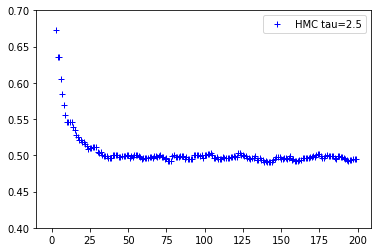

In [13]:
L = [8, 8, 8, 8]
grid = g.grid(L, g.double)

rng = g.random("test", "vectorized_ranlux24_24_64")
U = g.qcd.gauge.random(grid, rng)
Nd = len(U)

# conjugate momenta
mom = g.group.cartesian(U)

a0 = g.qcd.scalar.action.mass_term()
a1 = g.qcd.gauge.action.wilson(5.5)

def hamiltonian():
    a1v = a1(U)
    return a0(mom) + a1v, a1v

sympl = g.algorithms.integrator.symplectic

ip = sympl.update_p(mom, lambda: a1.gradient(U, U))
iq = sympl.update_q(U, lambda: a0.gradient(mom, mom))

mdint = sympl.OMF4(5, ip, iq)

metro = g.algorithms.markov.metropolis(rng)

def hmc(tau, mom):
    rng.normal_element(mom)
    accrej = metro(U)
    h0, s0 = hamiltonian()
    mdint(tau)
    h1, s1 = hamiltonian()
    return [accrej(h1, h0), s1 - s0, h1 - h0]

plaquette_hmc = []
accept = 0
total = 0
for it in range(200):
    plaq = g.qcd.gauge.plaquette(U)
    plaquette_hmc.append(plaq)
    a, dS, dH = hmc(1.5 if it < 10 else 2.5, mom)
    accept += a
    total += 1
    if it % 25 == 0:
        g.message(f"HMC {it} has P = {plaq}, dS = {dS}, acceptance = {accept/total}")
    
fig, ax = plt.subplots()

plt.ylim([0.4,0.7])
ax.plot(range(len(plaquette_hmc)), plaquette_hmc, marker='+', ls='', c='blue', label="HMC tau=2.5")

plt.legend()
plt.show()

## HMC generation of dynamical ensemble

In order to generate a dynamical fermion ensemble, we would like to generate
configurations in the path integral
$$
\begin{align}
Z = \int d[U] d\bar\psi d\psi e^{-S_G[U] - \sum_f \bar\psi_f D[U,m_f] \psi_f} 
= \int d[U] \left(\prod_f\det(D[U,m_f])\right)e^{-S_G[U]} \,,
\end{align}
$$
where the sum is over fermion flavors $f$ with masses $m_f$.  The determinant can
then be re-expressed using
$$
\begin{align}
\det(M)=\int d\phi d\phi^\dagger e^{-\phi^\dagger M^{-1} \phi} \,,
\end{align}
$$
which converges for positive definite $M$.  A single Dirac matrix is not positive
definite, however, due to $\gamma_5$-Hermiticity, one finds
$$
\begin{align}
\det(D) = \det(\gamma_5 D^\dagger \gamma_5) = \det(D^\dagger)
\end{align}
$$
such that for two degenerate flavors, we find
$$
\begin{align}
\det(D[U,m])^2 = \det(D[U,m] D[U,m]^\dagger) \,.
\end{align}
$$
Since the matrix $M=D[U,m] D[U,m]^\dagger$ is positive definite,
$$
\begin{align}
Z = \int d[U] \det(D[U,m])^2 e^{-S_G[U]} = \int d[U] d \phi d\phi^\dagger e^{-S_G[U] - \phi^\dagger (D[U,m] D[U,m]^\dagger)^{-1} \phi } \,.
\end{align}
$$
The bosonic fields $\phi$ are called **pseudo-fermion** fields.

If one wants to introducing a single additional flavor (such as a strange quark), one
may use rational approximations of the inverse square root as we have studied in the last chapter.  For now, however,
we focus on the important case of two degenerate quark flavors that in the real world,
we identify with the up and down quarks with degenerate mass $m = m_u = m_d$.  For high-precision
calculations, we will then later add corrections in the small $m_u - m_d$.

The concrete algorithm for the two-flavor HMC proceeds as follows.  We identify
$$
\begin{align}
\eta = D[U,m]^{-1} \phi
\end{align}
$$
such that
$$
\begin{align}
Z = \int d[U] d \phi d\phi^\dagger e^{-S_G[U] - \eta^\dagger \eta } \,.
\end{align}
$$
We then randomly draw a field configuration for $\eta$ from the trivial distribution
$$
\begin{align}
e^{-\eta^\dagger \eta}
\end{align}
$$
and compute
$$
\begin{align}
\phi = D[U,m] \eta \,.
\end{align}
$$
We then introduce conjugate momenta for the gauge fields, draw them randomly from a distribution
$$
\begin{align}
e^{-p^2/2}
\end{align}
$$
and perform the MD integration using the action
$$
\begin{align}
S[U,p] = S_G[U] + \phi^\dagger (D[U,m] D[U,m]^\dagger)^{-1} \phi + p^2/2 \,.
\end{align}
$$
We complete this process with an accept-reject step.

We show the implementation of an HMC for two dynamical degenerate quark flavors below:

In [2]:
import gpt as g

In [18]:
L = [8, 8, 8, 16]
grid = g.grid(L, g.double)

rng = g.random("test", "vectorized_ranlux24_24_64")
U = [g.project(x,"defect") for x in g.qcd.gauge.random(grid, rng)]
Nd = len(U)

# conjugate momenta
U_mom = g.group.cartesian(U)

rng.normal_element(U_mom)
    
# reproduce https://arxiv.org/pdf/hep-lat/0411006.pdf
a0 = g.qcd.scalar.action.mass_term()
a1 = g.qcd.gauge.action.improved_with_rectangle(0.8,-1.4069)
D_m = g.qcd.fermion.mobius(U, M5=1.8, mass=0.04, Ls=12, b=1., c=0., 
                           boundary_phases=[1,1,1,-1])
D_pv = g.qcd.fermion.mobius(U, M5=1.8, mass=1.0, Ls=12, b=1., c=0.,
                            boundary_phases=[1,1,1,-1])

inv = g.algorithms.inverter
pc = g.qcd.fermion.preconditioner
g.default.set_verbose("cg_convergence", False)
g.default.set_verbose("cg", False)
cg = inv.cg({"eps": 1e-8, "maxiter": 1000})

a2 = g.qcd.pseudofermion.action.two_flavor_ratio_evenodd_schur([D_m, D_pv], cg)

P = g.vspincolor(D_m.F_grid_eo)
fields = U + [P] 

sympl = g.algorithms.integrator.symplectic

show_force = False

def total_force():
    global show_force
    gauge_force = a1.gradient(U,U)
    fermion_force = a2.gradient(fields,U)
    if show_force:
        g.message("gauge force", (sum(g.norm2(gauge_force)) / 4 / P.grid.gsites)**0.5)
        g.message("fermion force", (sum(g.norm2(fermion_force)) / 4 / P.grid.gsites)**0.5)
        show_force = False
    return [g(x+y) for x,y in zip(gauge_force,fermion_force)]

ipU = sympl.update_p(U_mom, lambda: total_force())
iqUM = sympl.update_q(U, lambda: a0.gradient(U_mom, U_mom))

mdint = sympl.OMF4(5, ipU, iqUM)

metro = g.algorithms.markov.metropolis(rng)

def hamiltonian(draw):
    if draw:
        rng.normal_element(U_mom)
        a0v = a0(U_mom)
        a1v = a1(U)
        a2v = a2.draw(fields, rng)
    else:
        a0v = a0(U_mom)
        a1v = a1(U)
        a2v = a2(fields)
    return a0v + a1v + a2v, a1v + a2v


def hmc(tau):
    accrej = metro(U)
    h0, s0 = hamiltonian(True)
    mdint(tau)
    h1, s1 = hamiltonian(False)
    return [accrej(h1, h0), s1 - s0, h1 - h0]


plaquette_hmc = []
accept = 0
total = 0
for it in range(50):
    plaq = g.qcd.gauge.plaquette(U)
    plaquette_hmc.append(plaq)
    show_force = it % 10 == 0
    a, dS, dH = hmc(1.3 if it < 10 else 1.5)
    accept += a
    total += 1
    if it % 1 == 0:
        g.message(f"HMC {it} has P = {plaq}, dS = {dS}, dH = {dH}, acceptance = {accept/total}")

GPT :    3226.733732 s : Initializing gpt.random(test,vectorized_ranlux24_24_64) took 3.60012e-05 s
GPT :    3235.798564 s : gauge force 1.7894410341122076
GPT :    3235.801223 s : fermion force 0.17477311206344134
GPT :    3321.598793 s : HMC 0 has P = 0.7977536349278497, dS = 14125.963963725837, dH = -0.31147062371019274, acceptance = 1.0
GPT :    3418.014995 s : HMC 1 has P = 0.7239331849940017, dS = 8454.722610203899, dH = 0.05969532590825111, acceptance = 1.0
GPT :    3533.763383 s : HMC 2 has P = 0.6943358474812369, dS = 5455.348705547745, dH = 0.0858488124795258, acceptance = 1.0
GPT :    3656.958261 s : HMC 3 has P = 0.6760186855667949, dS = 3259.6686018415494, dH = 0.06032693374436349, acceptance = 1.0
GPT :    3792.405839 s : HMC 4 has P = 0.6654805318112572, dS = 1969.0264017770533, dH = 0.05946384253911674, acceptance = 0.8
GPT :    3932.168001 s : HMC 5 has P = 0.6654805318112572, dS = 2299.6916684884345, dH = 0.03148992813657969, acceptance = 0.8333333333333334
GPT :    4

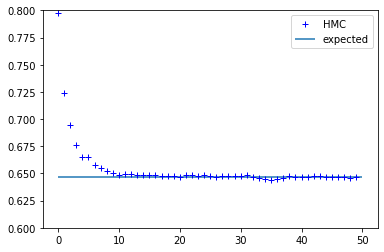

In [22]:
fig, ax = plt.subplots()

plt.ylim([0.6,0.8])
ax.plot(range(len(plaquette_hmc)), plaquette_hmc, marker='+', ls='', c='blue', label="HMC")
ax.hlines(0.646561,0,len(plaquette_hmc),label="expected")

plt.legend()
plt.show()